following the paper:
    
[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

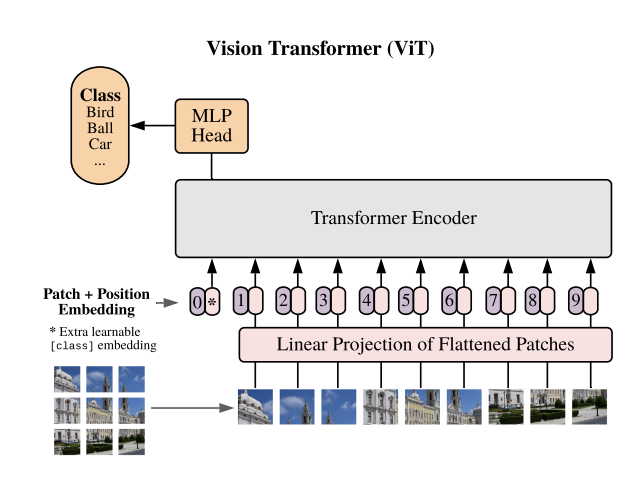

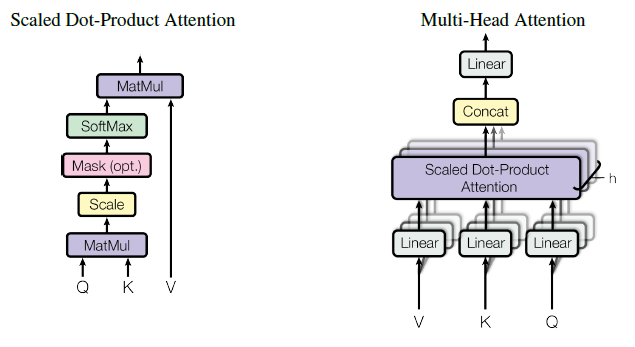

## Importing and pre-processing the data

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

In [2]:
print(f'torch version: {torch.__version__}')

#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

torch version: 1.13.0+cpu
using device: cpu


### Examining the dataset

Challenges: Class names are in a different language

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

In [7]:
# brain-mri-images-for-brain-tumor-detection
import requests
import zipfile
from pathlib import Path
import os

# Setup path to data folder
data_path = Path("/kaggle/input/animals10/raw-img")

for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 10 directories and 0 images in '/kaggle/input/animals10/raw-img'.
There are 0 directories and 2623 images in '/kaggle/input/animals10/raw-img/cavallo'.
There are 0 directories and 1820 images in '/kaggle/input/animals10/raw-img/pecora'.
There are 0 directories and 1446 images in '/kaggle/input/animals10/raw-img/elefante'.
There are 0 directories and 1668 images in '/kaggle/input/animals10/raw-img/gatto'.
There are 0 directories and 1862 images in '/kaggle/input/animals10/raw-img/scoiattolo'.
There are 0 directories and 3098 images in '/kaggle/input/animals10/raw-img/gallina'.
There are 0 directories and 4821 images in '/kaggle/input/animals10/raw-img/ragno'.
There are 0 directories and 1866 images in '/kaggle/input/animals10/raw-img/mucca'.
There are 0 directories and 4863 images in '/kaggle/input/animals10/raw-img/cane'.
There are 0 directories and 2112 images in '/kaggle/input/animals10/raw-img/farfalla'.


Random image path: /kaggle/input/animals10/raw-img/ragno/e83cb0062ff5073ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb3b9_640.jpg
Image class: ragno
Image height: 422
Image width: 640


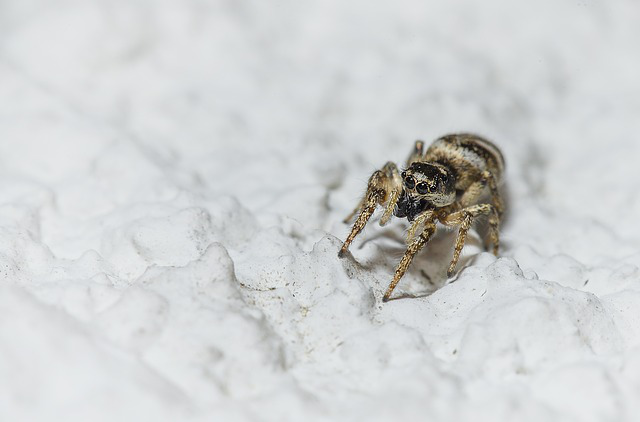

In [9]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(data_path.glob("*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

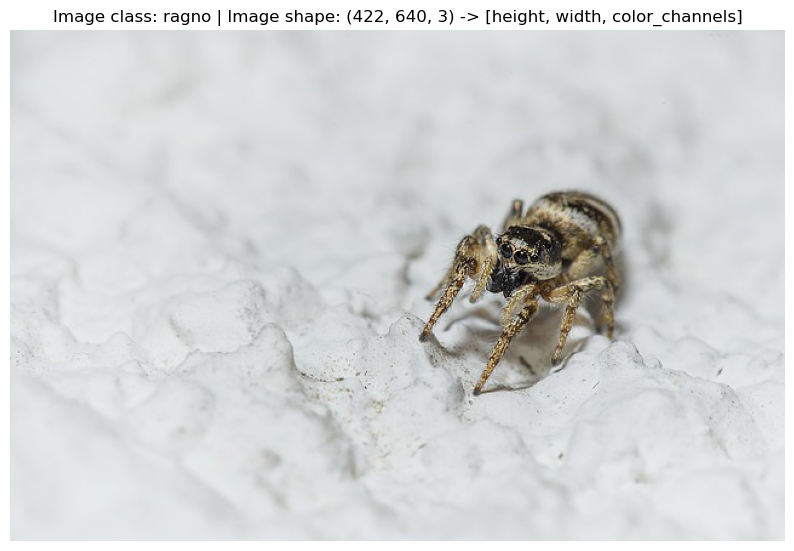

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [34]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [35]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
#     transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [36]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
data_path = Path("/kaggle/input/animals10/raw-img")
full_data = datasets.ImageFolder(root=data_path, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

print(f"Train data:\n{full_data}\n")

Train data:
Dataset ImageFolder
    Number of datapoints: 26179
    Root location: /kaggle/input/animals10/raw-img
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )



In [47]:
class_names = full_data.classes

In [48]:
class_to_idx = full_data.class_to_idx

In [49]:
len(full_data)

26179

In [50]:
translate_dict = {"cane": "dog",
                  "cavallo": "horse",
                  "elefante": "elephant",
                  "farfalla": "butterfly",
                  "gallina": "chicken",
                  "gatto": "cat",
                  "mucca": "cow",
                  "pecora": "sheep",
                  "ragno" : "spider",
                  "scoiattolo": "squirrel"}
# new_classes = []
# print(full_data.classes)
# for class_name in full_data.classes:
#     new_classes.append(translate_dict[class_name])
# full_data.classes = new_classes
# print()
translate_dict

{'cane': 'dog',
 'cavallo': 'horse',
 'elefante': 'elephant',
 'farfalla': 'butterfly',
 'gallina': 'chicken',
 'gatto': 'cat',
 'mucca': 'cow',
 'pecora': 'sheep',
 'ragno': 'spider',
 'scoiattolo': 'squirrel'}

In [51]:
img, label = full_data[0][0], full_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.9059, 0.9020, 0.8980,  ..., 0.9412, 0.9412, 0.9451],
         [0.9059, 0.9020, 0.8980,  ..., 0.9412, 0.9412, 0.9451],
         [0.9020, 0.8980, 0.8941,  ..., 0.9373, 0.9373, 0.9412],
         ...,
         [0.3373, 0.3294, 0.3255,  ..., 0.9529, 0.9529, 0.9529],
         [0.3333, 0.3294, 0.3255,  ..., 0.9529, 0.9529, 0.9529],
         [0.3569, 0.3255, 0.3255,  ..., 0.9569, 0.9569, 0.9529]],

        [[0.9059, 0.9020, 0.8980,  ..., 0.9137, 0.9137, 0.9176],
         [0.9059, 0.9020, 0.8980,  ..., 0.9137, 0.9137, 0.9176],
         [0.9020, 0.8980, 0.8941,  ..., 0.9098, 0.9098, 0.9137],
         ...,
         [0.3451, 0.3373, 0.3333,  ..., 0.9333, 0.9333, 0.9333],
         [0.3412, 0.3373, 0.3333,  ..., 0.9333, 0.9333, 0.9333],
         [0.3647, 0.3333, 0.3333,  ..., 0.9373, 0.9373, 0.9333]],

        [[0.8667, 0.8627, 0.8588,  ..., 0.8902, 0.8902, 0.8941],
         [0.8667, 0.8627, 0.8588,  ..., 0.8902, 0.8902, 0.8941],
         [0.8627, 0.8588, 0.8549,  ..., 0.88

Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


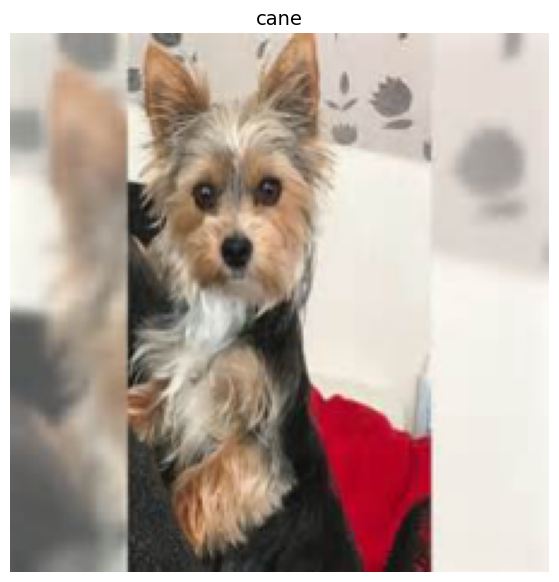

In [52]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [59]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
BATCH_SIZE = 64
SEED = 3

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(full_data)),
    full_data.targets,
    stratify=full_data.targets,
    test_size=TEST_SIZE,
    random_state=SEED
)

# generate subset based on indices
train_split = Subset(full_data, train_indices)
test_split = Subset(full_data, test_indices)

# create batches
train_dataloader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_split, batch_size=BATCH_SIZE)

print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {BATCH_SIZE}")

train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
print(test_features_batch.shape, test_labels_batch.shape)

Length of train_dataloader: 328 batches of size 64
Length of test_dataloader: 82 batches of size 64
torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'scoiattolo | squirrel')

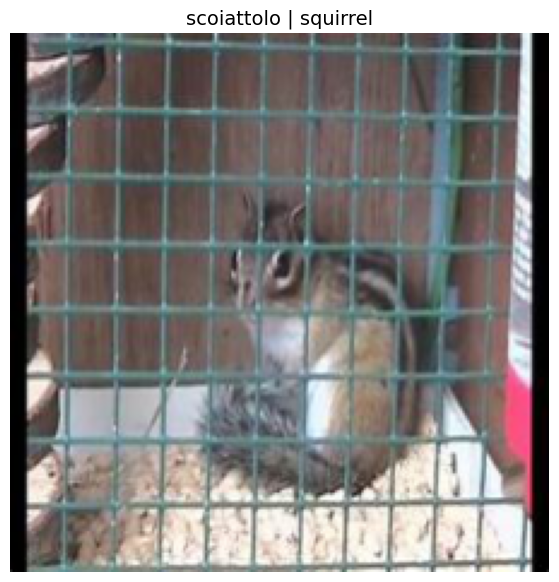

In [71]:
image = train_features_batch[3]
label = train_labels_batch[3]
image.shape
# Rearrange the order of dimensions
img_permute = image.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {image.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
french_name = class_names[label.item()]
plt.title(french_name + " | " + translate_dict[french_name], fontsize=14)

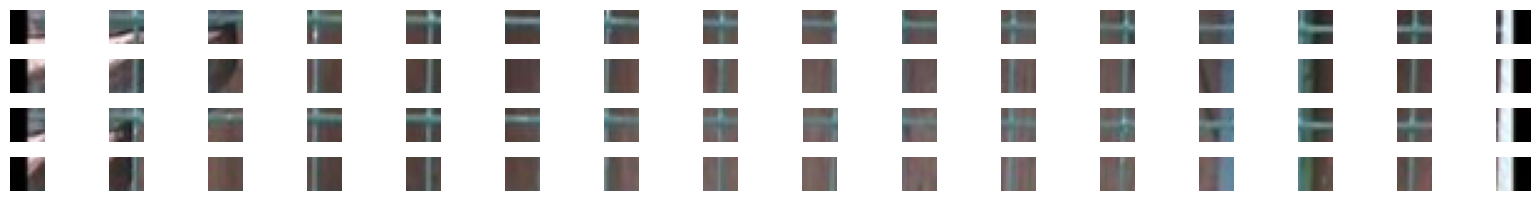

In [371]:
# image.shape = torch.Size([3, 224, 224])
image = train_features_batch[3]
label = train_labels_batch[3]

# Generating 16 56 x 56 pixel squares
patches = []
for y in range(16):
    for x in range(16):
        patches.append(image[:, 14*(y):14*(y+1), 14*x:14*(x+1)])
plt.figure(figsize=(16, 8))
for i in range(64):
    targ_image = patches[i]
    targ_image_adjust = targ_image.permute(1, 2, 0)
    plt.subplot(16, 16, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
plt.tight_layout()


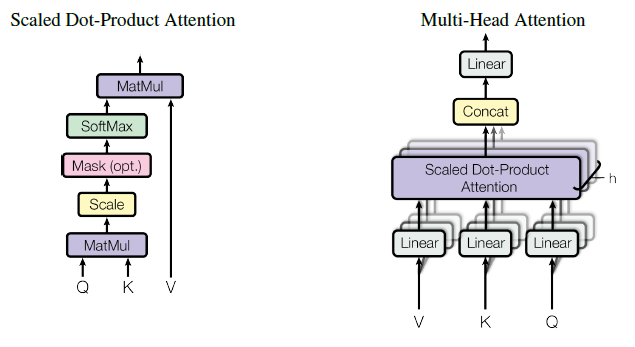

In [233]:
h = 8 # parallel attention layers/heads
d_k = 64 #queries, keys dimension
d_v = 64 # values 
d_model = 512 

linear_projection = torch.nn.Sequential(
    torch.nn.Linear(in_features=9408, #3*56*56
                    out_features=d_k, # same number of output units as our number of classes
                    bias=True)).to(device)


transformer_inputs_array = []
for patch in patches: 
    patch = patch.to(device)
    patch_flattened = torch.flatten(patch) # torch.Size([3, 56, 56]) - > torch.Size([9408])
    #Can run this vectorised to make the model more efficient
    patch_projected = linear_projection(patch_flattened) # #9408 -> 64 dim vector
    
    ### Add positional encoding ###
    
    transformer_inputs_array.append(patch_projected.unsqueeze(dim=0))
    
transformer_inputs = torch.cat(transformer_inputs_array) # torch.Size([16, 64])
transformer_inputs.shape

torch.Size([16, 64])

In [283]:
# Generate queries, keys and values
Q = transformer_inputs[0]
K = transformer_inputs[1]
V = transformer_inputs[2]
print(Q.shape)

WQ = torch.rand(h, d_model, d_k)
WK = torch.rand(h, d_model, d_k)
WV = torch.rand(h, d_model, d_v)
print(WQ.shape)

torch.Size([64])
torch.Size([8, 512, 64])


In [286]:
def Attention(Q, K, V):    
    print("Before unsqueeze:", Q.shape, K.shape, V.shape)
    Q = Q.unsqueeze(dim=1)
    K = K.unsqueeze(dim=1)
    V = V
    print("After unsqueeze:", Q.shape, K.shape, V.shape)
    return torch.softmax((Q @ K.T)/math.sqrt(h), dim = 1) @ V #(d_k x d_k) @ (d_v)
attention_output = Attention(Q, K, V)
print("attention_output", attention_output.shape)

Before unsqueeze: torch.Size([64]) torch.Size([64]) torch.Size([64])
After unsqueeze: torch.Size([64, 1]) torch.Size([64, 1]) torch.Size([64])
attention_output torch.Size([64])


In [350]:
#Fully expanded function
def MultiHeadAttentionLong(Q_, K_, V_):
    # keep 1 channel independent (each is a different head)

    #Q_.shape, K_.shape  (torch.Size([8, 512]), torch.Size([8, 512]))
    Q_ = Q_.unsqueeze(dim=2)
    K_ = K_.unsqueeze(dim=2)
    #Q_.shape, K_.shape (torch.Size([8, 512, 1]), torch.Size([8, 512, 1]))
    K_permuted = K_.permute(0, 2, 1) #torch.Size([8, 1, 512])
    mat_mul = (Q_ @ K_permuted)/math.sqrt(h) # ([8, 512, 1]) x([8, 1, 512]) = torch.Size([8, 512, 512])
    softmaxed = torch.softmax(mat_mul, dim = 2)
    V_unsqueezed = V_.unsqueeze(dim=2) # torch.Size([8, 1, 512])
    output_expanded = (softmaxed @ V_unsqueezed) # ([8, 512, 1]) x ([8, 512, 512]) = ([8, 512, 1])
    output = output_expanded.squeeze() 
    return output # torch.Size([8, 512])

result1 = MultiHeadAttentionLong(WQ @ Q, WK @ K, WV @ V)
result1.shape

torch.Size([8, 512])

In [363]:
#Fully expanded function
def MultiHeadAttention(Q_, K_, V_):
    # keep each channel independent (each is a different head)
    return (torch.softmax((Q_.unsqueeze(dim=2) @ K_.unsqueeze(dim=1))/math.sqrt(h),dim = 2)@V_.unsqueeze(dim=2)).squeeze(dim=2)
result2 = MultiHeadAttention(WQ @ Q, WK @ K, WV @ V)
result2.shape

torch.Size([8, 512])

In [364]:
result1 == result2

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [370]:
def MultiHeadAttention(Q_, K_, V_):
    # keep each channel independent (each is a different head)
    return (torch.softmax((Q_.unsqueeze(dim=2) @ K_.unsqueeze(dim=1))/math.sqrt(h),dim = 2)@V_.unsqueeze(dim=2)).squeeze(dim=2)


class ViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.h = 8 # parallel attention layers/heads
        self.d_k = 64 #queries, keys dimension
        self.d_v = 64 # values 
        self.d_model = 512 
        
        
        #Linear projection of flattened patches
        self.projection = nn.Sequential(
            nn.Linear(in_features=9408,
                      out_features=self.d_k))
        
        #Learnable parameters
        WQ = torch.rand(h, d_model, d_k)
        WK = torch.rand(h, d_model, d_k)
        WV = torch.rand(h, d_model, d_v)
        
        self.MLP = nn.Sequential(
            nn.Linear(in_features=512,
                      out_features=50),
            nn.GeLU(),
            nn.Linear(in_features=512,
                      out_features=10))
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #16 patches vertically next to each other
        #1. run through linear projection
        #2. add positional embedding
        #3. Find K, Q, V
        
        #4. Pass data through MultiHeadAttention
        Transformer_encoder_output = MultiHeadAttention(WQ @ Q, WK @ K, WV @ V) # torch.Size([8, 512])
        
        #5. Final Linear MLP
        logits = self.MLP(Transformer_encoder_output)
        #6. Classifications
        return logits
    

In [366]:
patches[0].shape

torch.Size([3, 56, 56])

In [368]:
3*56*56

9408